- 파이썬으로 다양한 팩터 모델을 추정하는 내용
- 하나 이상의 팩터(특징)을 사용해 특정 포트폴리오나 자산의 초과 수익을 설명하는 것
- 수익의 단면을 이해하는 도구

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip install yfinance
!pip install statsmodels.api

# 1. 파이썬으로 CAPM 구현
- **자본 자산 가격 모델 (CAPM)을 추정**하고 **베타 계수**를 얻는 방법
- 위험 자산에 대한 예상 수익률과 시장 위험 간의 관계
- 단일 팩터 모델

## 자본 자산 가격 모델 (**C**apital **A**sset **P**ricing **M**odel)
- https://m.blog.naver.com/carrot_1027/220780295571[참고] 
- 자본자산들의 가격을 결정하는 모델
___
### **E(r<sub>i</sub>)  =  r<sub>f</sub>  +  β<sub>i</sub> ( E(r<sub>m</sub>) - r<sub>f</sub> )**
- 자산 i의 기대수익률 = 무위험금리 + β(시장 기대수익률 - 무위험금리)
- 무위험금리 : 아무 위험없이 취할 수 있는 금리(수익률)
- β베타 계수 : 시장 대비 자산 수익률의 민감도 수준 (= 시장에 대한 민감도)
- 1. β <= -1 : 자산이 벤치 마크와 반대 방향. 벤치 마크의 음수보다 더 큰 정도로 이동
- 2. -1< β <0 : 자산이 벤치 마크와 반대 방향으로 이동
- 3. β = 0 : 자산의 가격 변동과 시장 벤치 마크 사이에 상관관계X
- 4. 0< β <1 : 자산이 시장과 같은 방향으로 움직이지만, 크기는 더 작다. ex) 일별 변동에 크게 영향 받지 않는 주식의 경우
- 5. β = 1 : 자산과 시장이 같은 방향과 크기로 이동
- 6. β > 1 : 자산이 시장과 같은 방향, 더 큰 정도로 이동. ex) 시장의 일상 뉴스에 매우 민감한 회사의 주식
___
### **E(r<sub>i</sub>) - r<sub>f</sub> =  β<sub>i</sub> ( E(r<sub>m</sub>) - r<sub>f</sub> )**
- 좌변 = 위험 프리미엄 = R<sub>i</sub>, 우변 = 시장 프리미엄 = R<sub>m</sub>
- β= cov(R<sub>i</sub>, R<sub>m</sub>) / var(R<sub>m</sub>)


In [4]:
# 라이브러리 불러오기
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

In [5]:
# 위험 자산과 시간 구간 명시
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = '^GSPC'
START_DATE = '2014-01-01'
END_DATE = '2018-12-31'

In [6]:
# 야후 파이낸스에서 데이터 다운로드
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True,
                 progress=False)

In [7]:
# 월별 데이터로 리샘플링, 단순 수익률 계산
## pct_change 메서드 : 현재와 이전 원소 사이의 백분율 변화 계산
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', 
                                    MARKET_BENCHMARK: 'market'}) \
                   .resample('M') \
                   .last() \
                   .pct_change() \
                   .dropna()
X.head()

,asset,market
Date,,
2014-02-28,0.009507,0.043117
2014-03-31,-0.071058,0.006932
2014-04-30,-0.095847,0.006201
2014-05-31,0.027685,0.021030
2014-06-30,0.039130,0.019058


In [8]:
# 공분산 기법 사용해서 beta 계산
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance/benchmark_variance
beta

1.6296083359501388

In [9]:
# 입력 준비, CAPM을 선형 회귀로 추정
# separate target
y = X.pop('asset')

# add constant : 1로 구성된 상수열 추가
X = sm.add_constant(X)

# define and fit the regression model 
capm_model = sm.OLS(y, X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     32.77
Date:                Sat, 26 Mar 2022   Prob (F-statistic):           4.05e-07
Time:                        01:02:42   Log-Likelihood:                 75.313
No. Observations:                  59   AIC:                            -146.6
Df Residuals:                      57   BIC:                            -142.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0178      0.009      1.950      0.0

- 결과 : **베타(표에서 market) = 1.6296**
- **아마존의 수익률이 시장(S&P)보다 약 63% 더 변동성이 있다**는 의미
- 절편값은 상대적으로 작고 5% 유의 수준에서 통계적으로 유의
- 회귀에 절편을 추가하는 이유 : 모형을 추정한 후 절편이 0인지 조사
- 절편이 양수이고 유의하면 CAPM 모델이 참이라는 가정하에서 자산이나 포트폴리오가 비정상적으로 높은 위험 조정 수익 창출함을 의미
- 원인 1: 시장이 비효율적
- 원인 2: 모델에 포함되어야 할 발견되지 않은 다른 위험 팩터 존재 -> **조인트 가설 문제**
- OLS 회귀 : 최소자승법(OLS: Ordinary Least Squares). 잔차제곱합(RSS: Residual Sum of Squares)를 최소화하는 가중치 벡터를 구하는 방법

## 추가 사항
- 예제에서는 무위험 금리를 0으로 가정했지만, **0이 아닌 무위험 금리를 고려해야 하는 경우** 존재 -> 3가지 접근 방식
- 1. 케네스 프렌치 교수의 웹 사이트 데이터 이용
- 2. 13주(3개월) 국채(야후 파이낸스 티커 심벌: ^IRX) 사용
- 3. FRED 데이터베이스에서 3개월 국재 사용
- 다음 단계에 따라 데이터 다운로드하고, 적절한 *무위험 금리 변환하는 방법*을 알아보자

In [10]:
# 기간을 일로 정의
N_DAYS = 90

In [11]:
# 야후 파이낸스에서 데이터 다운로드
df_rf = yf.download('^IRX', start=START_DATE, end=END_DATE)

[*********************100%***********************]  1 of 1 completed


In [12]:
# 데이터를 월간 주기로 리샘플링
rf = df_rf.resample('M').last().Close / 100

In [13]:
# 무위험 수익률 계산, 월별로 반환
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  
rf = (rf ** 30) - 1 

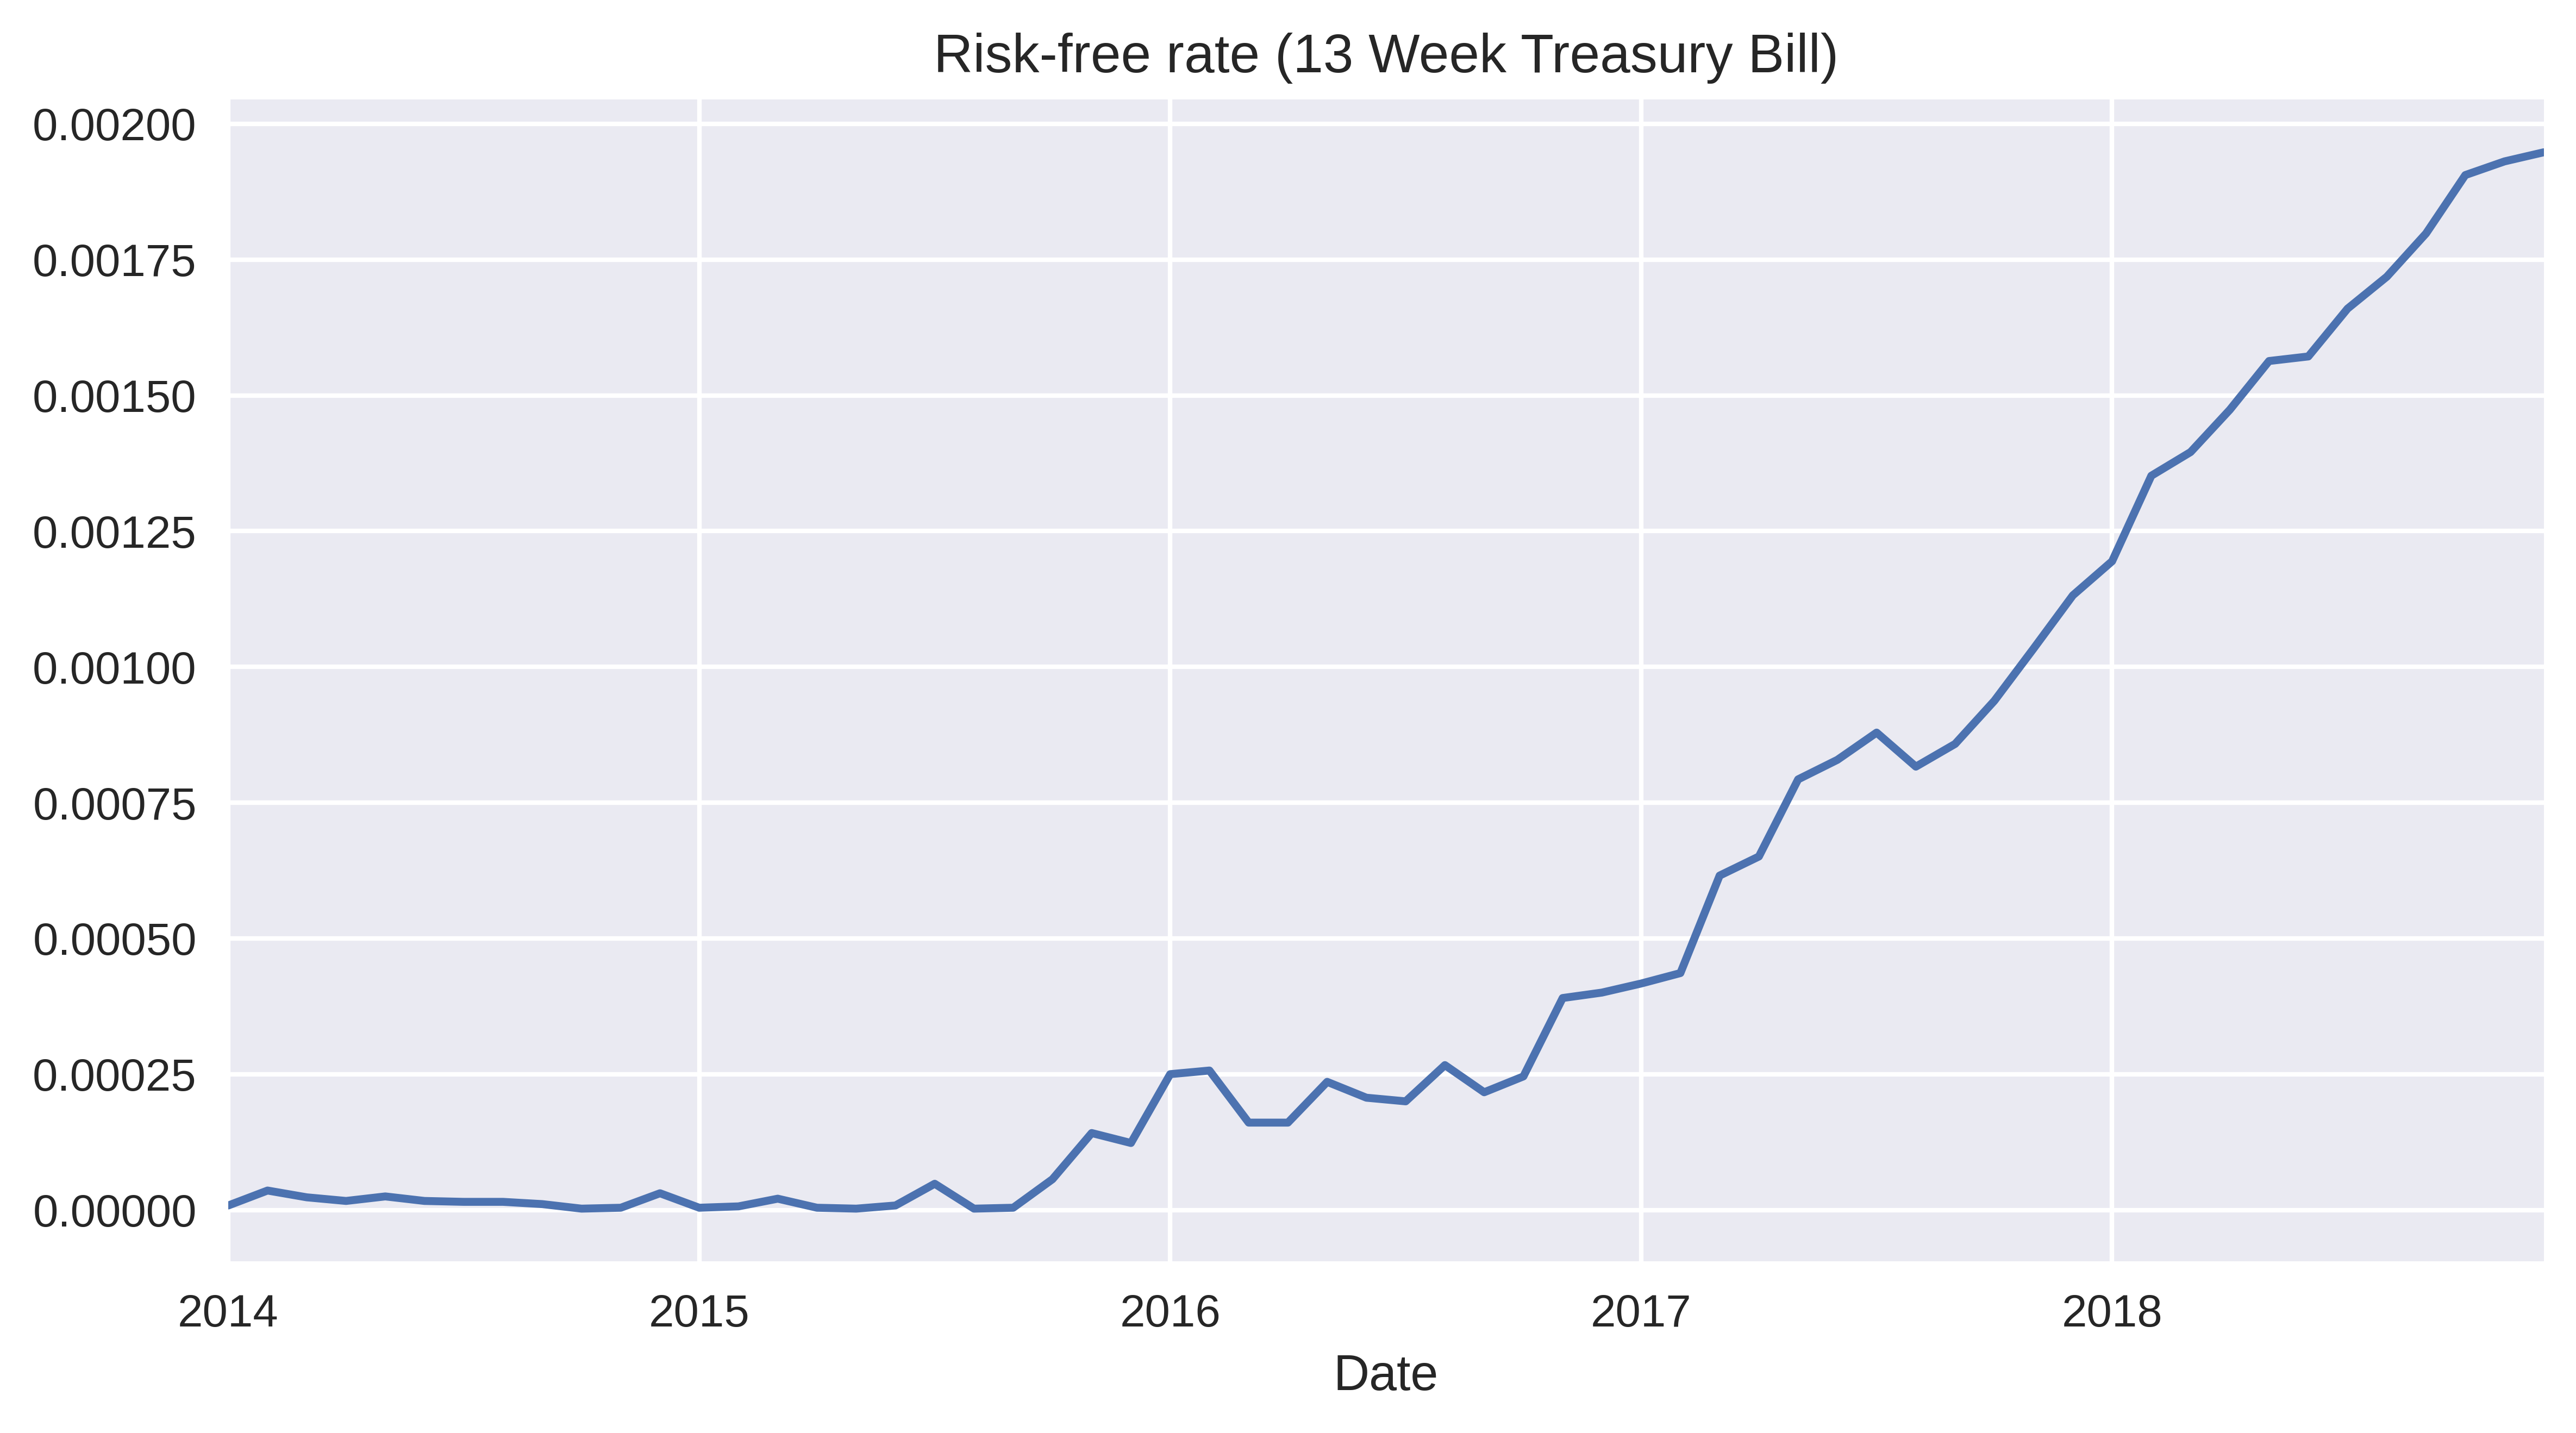

In [14]:
# 계산된 무위험 금리 계산
rf.plot(title='Risk-free rate (13 Week Treasury Bill)')
plt.tight_layout()
plt.show()

- 시간에 따른 무위험 금리

#### FRED 방법

In [15]:
# 라이브러리 불러오기
import pandas_datareader.data as web

In [16]:
# FRED 데이터베이스에서 데이터 다운로드
rf = web.DataReader('TB3MS', 'fred', start=START_DATE, end=END_DATE)

In [17]:
# 구한 무위험 금리를 월별 값으로 변환
rf = (1+(rf/100))**(1/12)-1

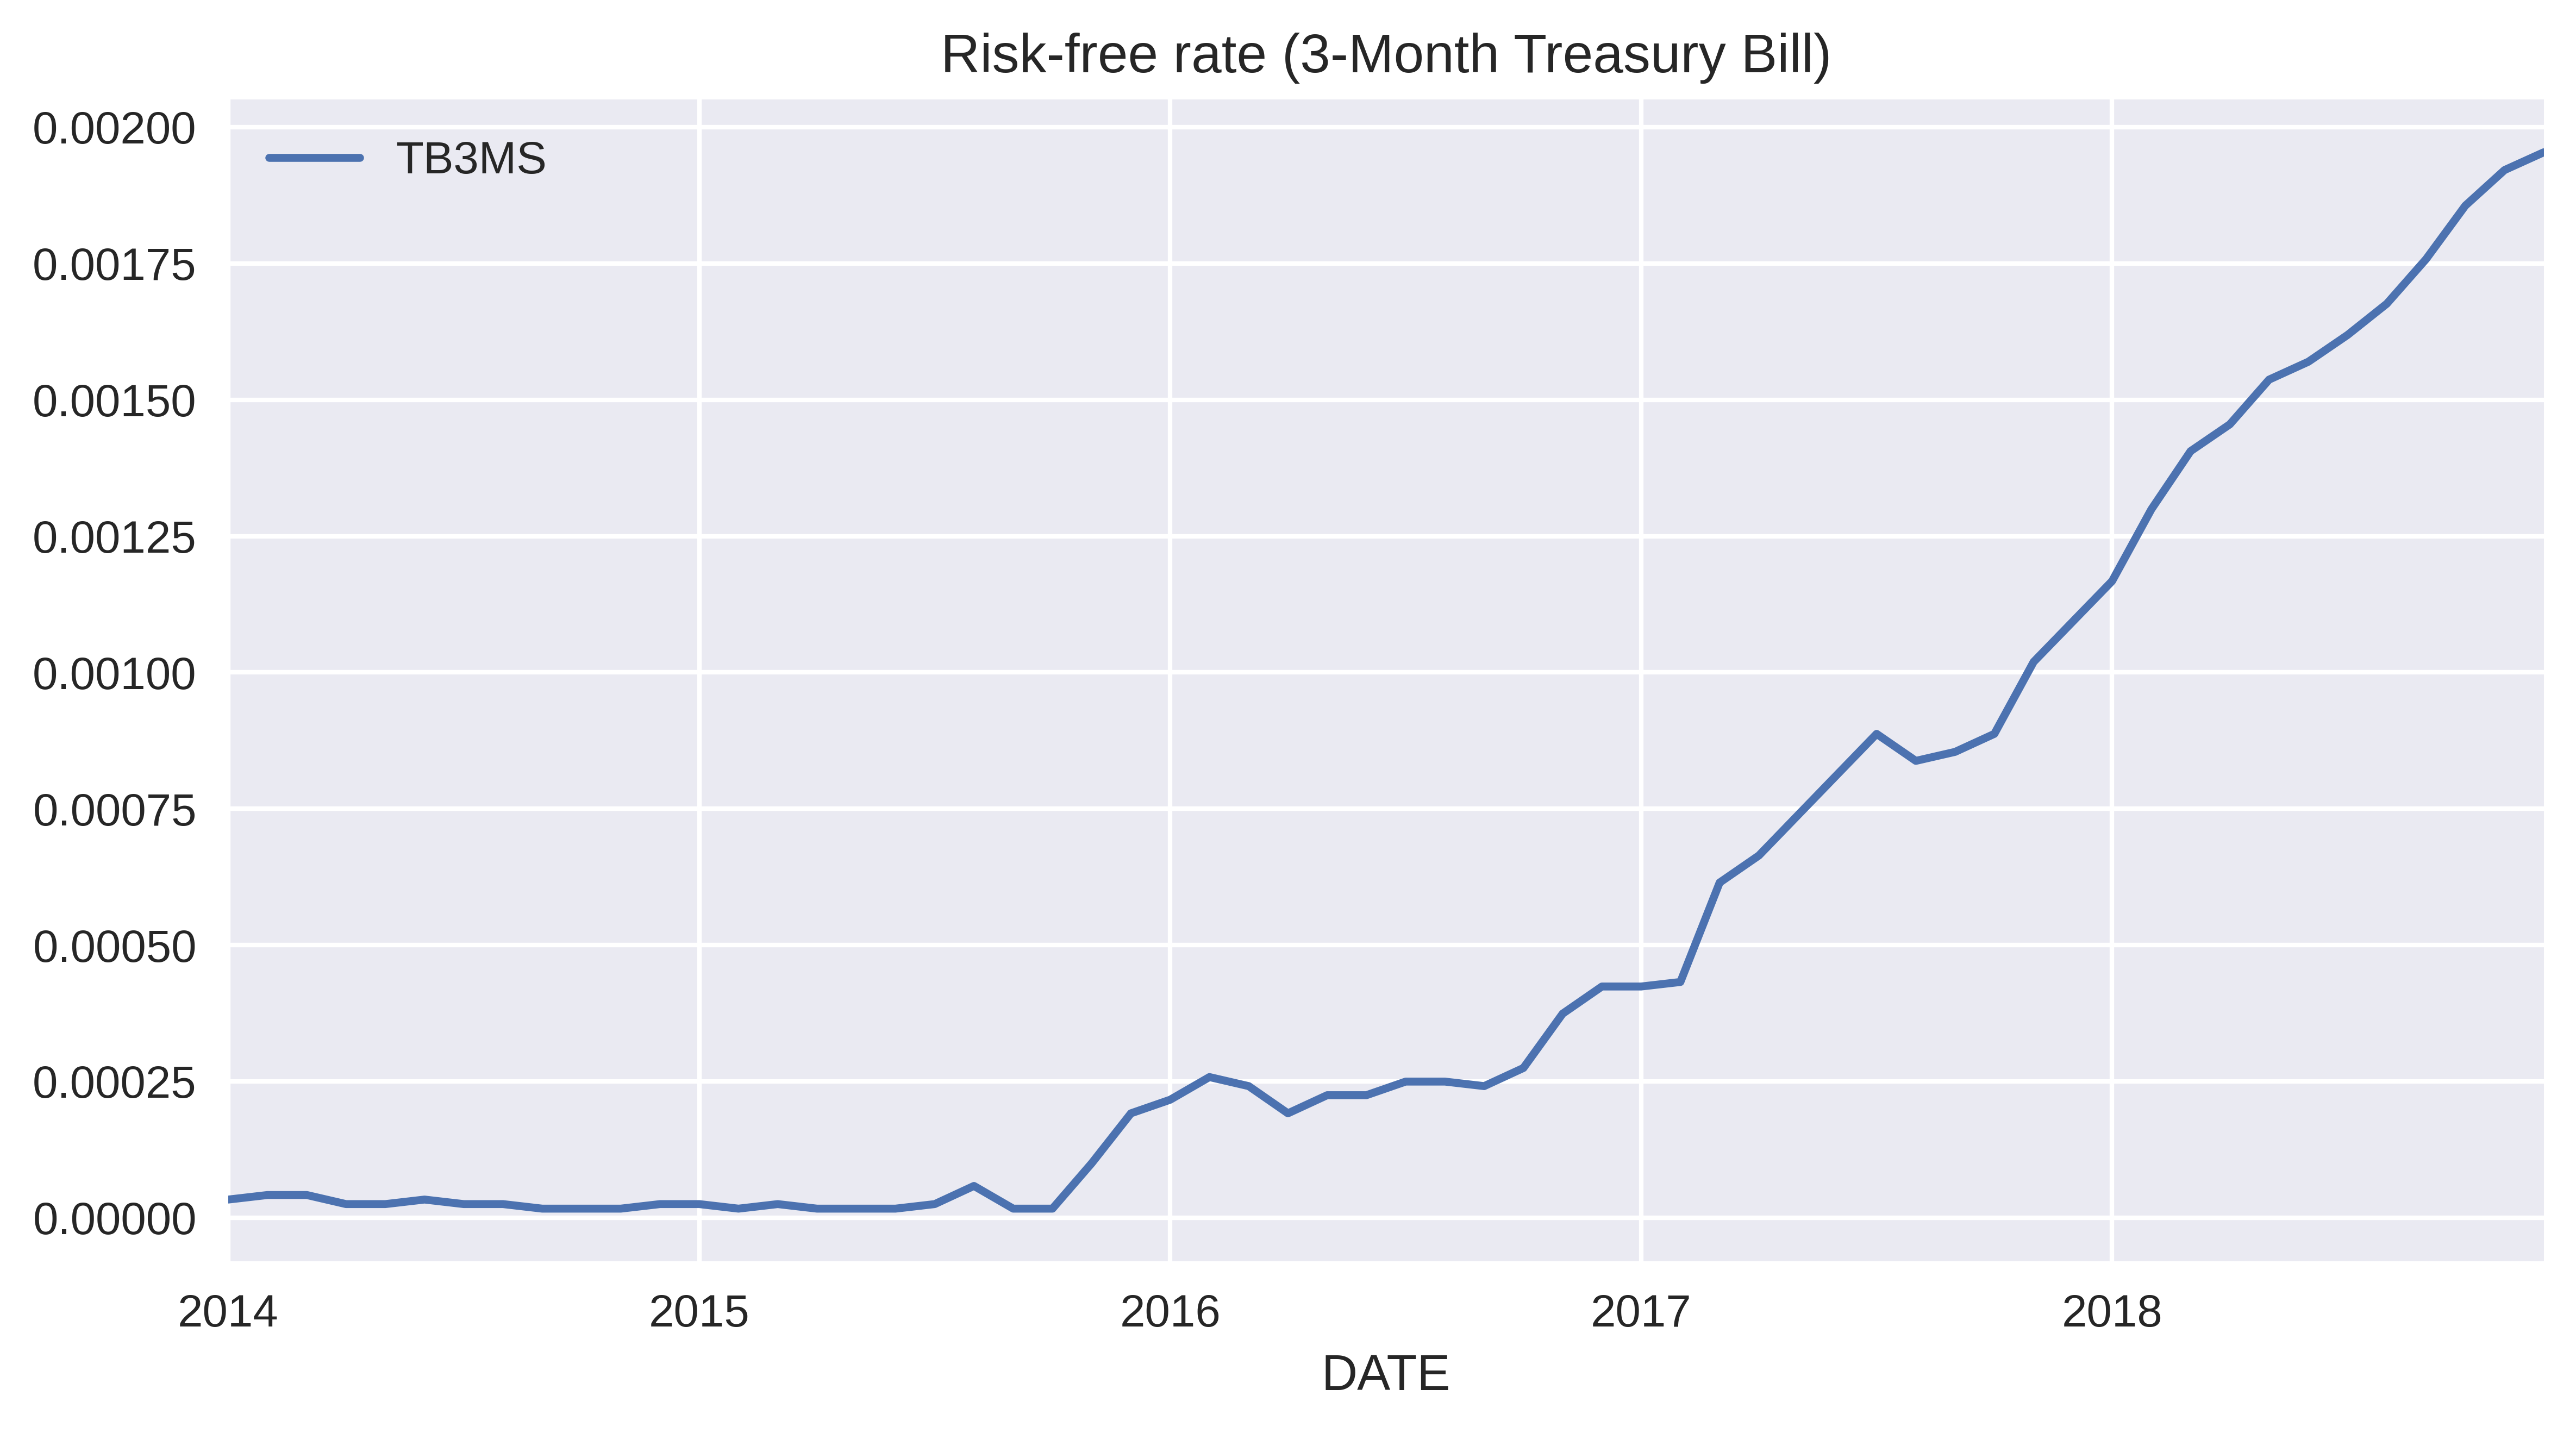

In [18]:
# 계산한 무위험 금리 도식화
rf.plot(title='Risk-free rate (3-Month Treasury Bill)')

plt.tight_layout()
plt.show()

- 앞의 도면과 매우 유사

# 2. 파이썬으로 파마-프렌치 3-팩터 모델 구현
- 자산이나 포트폴리오의 초과 수익을 설명하는 두 가지 팩터를 추가해 CAPM 모델 확장
- <고려한 팩터>
- 1. 시장 팩터 MKT : CAPM과 유사한 시장의 초과 수익률 측정
- 2. 크기 팩터 SMB : 시가 총액이 큰 주식 대비 시가 총액이 작은 주식의 초과 수익률 측정
- 3. 가치 팩터 HML : 성장 주식 대비 초과 가치 주식의 초과 수익률 측정. 가치 주식은 높은 시장가-대비-장부가 비율을 갖고 성장 주식은 그 비율이 낮다.
- 페이스북의 5년 월별 수익률을 사용해 3-팩터 모델 추정

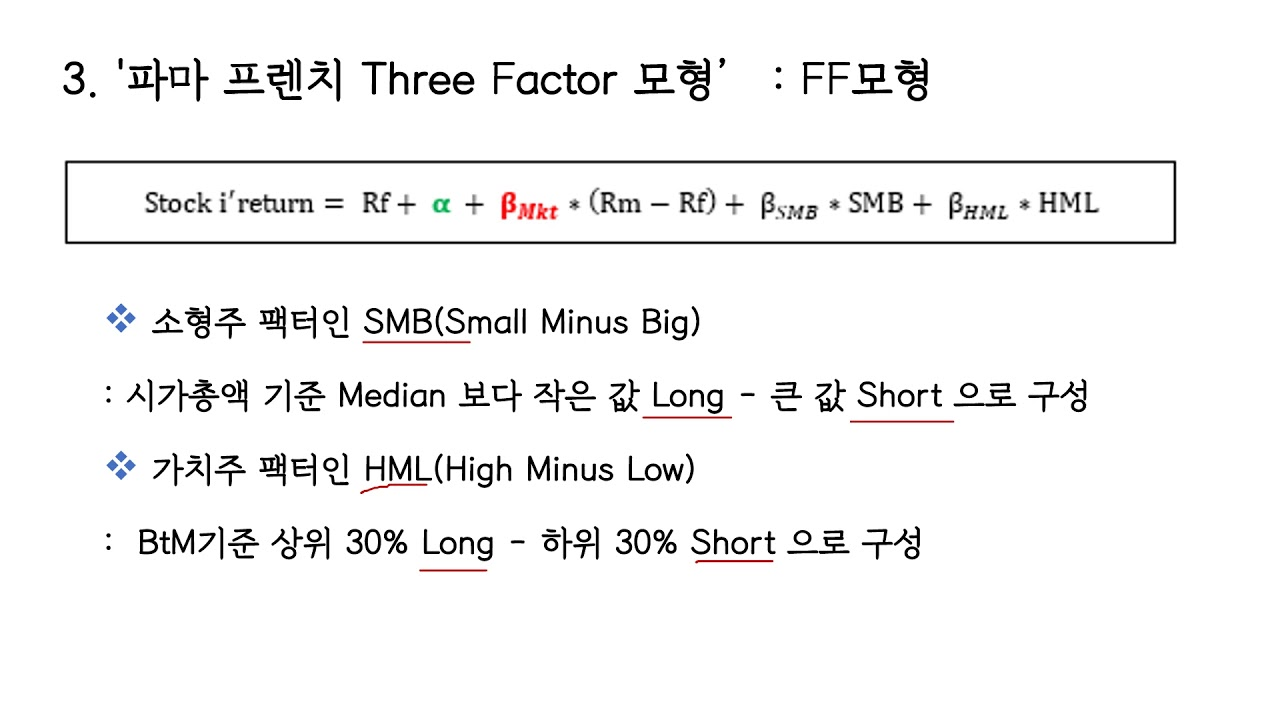

- 좌변 : 자산 i에 대한 기대 수익률
- R<sub>f</sub> : 무위험 금리 ex)정부 채권
- α : 절편 -> 값이 0인지 확인하기 위해 포함

In [26]:
# 라이브러리 불러오기
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf

In [28]:
# 프렌치 교수 웹사이트에서 필요 데이터 다운로드
# download the zip file from Prof. French's website
!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip

# unpack the zip
!unzip -a F-F_Research_Data_Factors_CSV.zip

# remove the zip
!rm F-F_Research_Data_Factors_CSV.zip

--2022-03-26 01:17:41--  http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.171.144
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.171.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12579 (12K) [application/x-zip-compressed]
Saving to: ‘F-F_Research_Data_Factors_CSV.zip’

F-F_Research_Data_F 100%[===================>]  12.28K  --.-KB/s    in 0s      

2022-03-26 01:17:41 (182 MB/s) - ‘F-F_Research_Data_Factors_CSV.zip’ saved [12579/12579]

Archive:  F-F_Research_Data_Factors_CSV.zip
replace F-F_Research_Data_Factors.CSV? [y]es, [n]o, [A]ll, [N]one, [r]ename: ㅛ
error:  invalid response [ㅛ]
replace F-F_Research_Data_Factors.CSV? [y]es, [n]o, [A]ll, [N]one, [r]ename: ㅛ
error:  invalid response [ㅛ]
replace F-F_Research_Data_Factors.CSV? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: F-F_Research_Data_Factors.CSV  [binary]


In [41]:
# 매개 변수 정의
RISKY_ASSET = 'FB'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

In [42]:
## 소스 CSV 파일에서 데이터 로드하고 월별 데이터만 남긴다.
# load data from csv
factor_df = pd.read_csv("F-F_Research_Data_Factors.CSV", skiprows=3)

# identify where the annual data starts
STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]

# keep only monthly data
factor_df = factor_df[factor_df.index < start_of_annual]

In [43]:
## DataFrame의 열 이름 변경, datetime을 인덱스로 지정한 다음 날짜로 필터링
# rename columns
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']

# convert strings to datetime
factor_df['date'] = pd.to_datetime(factor_df['date'], 
                                   format='%Y%m') \
                      .dt.strftime("%Y-%m")

# set index
factor_df = factor_df.set_index('date')

# filter only required dates
factor_df = factor_df.loc[START_DATE:END_DATE]

In [44]:
# 값을 수치로 바꾸고 100으로 나눈다.
factor_df = factor_df.apply(pd.to_numeric, 
                            errors='coerce') \
                     .div(100)
factor_df.head()

,mkt,smb,hml,rf
date,,,,
2014-01,-0.0332,0.0092,-0.0202,0.0
2014-02,0.0465,0.0037,-0.0031,0.0
2014-03,0.0043,-0.0187,0.0492,0.0
2014-04,-0.0019,-0.0420,0.0114,0.0
2014-05,0.0206,-0.0189,-0.0013,0.0


In [45]:
# 위험 자산의 가격 다운로드
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


In [48]:
# 위험 자산에 대해 월별 수익률 계산
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'
y.head()

Date
2014-01    0.144922
2014-02    0.094135
2014-03   -0.120070
2014-04   -0.007636
2014-05    0.058883
Name: rtn, dtype: float64

- DataFrame과 pandas Series를 조인하기 위한 필요 사항
- -> y.name='rtn'을 사용해 **pandas Series 이름을 지정!**

In [39]:
# 데이터셋을 병합하고 초과 수익률 계산
ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf
ff_data.head()

,mkt,smb,hml,rf,rtn,excess_rtn
date,,,,,,
2014-01,-0.0332,0.0092,-0.0202,0.0,0.144922,0.144922
2014-02,0.0465,0.0037,-0.0031,0.0,0.094135,0.094135
2014-03,0.0043,-0.0187,0.0492,0.0,-0.120070,-0.120070
2014-04,-0.0019,-0.0420,0.0114,0.0,-0.007636,-0.007636
2014-05,0.0206,-0.0189,-0.0013,0.0,0.058883,0.058883


In [40]:
## 3-팩터 모델 추정
# define and fit the regression model 
ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', 
                   data=ff_data).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     5.066
Date:                Sat, 26 Mar 2022   Prob (F-statistic):            0.00357
Time:                        01:21:24   Log-Likelihood:                 88.254
No. Observations:                  60   AIC:                            -168.5
Df Residuals:                      56   BIC:                            -160.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0105      0.008      1.367      0.1

- **3-팩터 모델 결과 해석 시 주의 사항**
- 1. 절편이 양이면서 통계적으로 유의한가?
- 2. 어떤 팩터가 통계적으로 유의하며 방향성이 과거 결과나 가정들에 매칭되는가?
___
- <해석>
- 1. 절편은 양이지만 5% 유의 수준에서 통계적으로 유의하지 X
- 2. 위험 팩터 중 SMB 팩터만 유의하지 않다.
- 3. 귀무 가설 : 절편을 제외한 모든 특징(팩터) 계수 값이 0이다 -> p-value=0.00317 이므로 기각!


## 추가 사항)
- 프렌치 교수의 웹사이트에서 직접 팩터 관련 데이터 다운로드 방법 이외에 다른 방법
- **pandas_datareader 기능**을 사용하여 수작업 전처리 단계X

In [49]:
# 라이브러리 불러오기
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

In [50]:
# 사용할 수 있는 데이터셋 출력
get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

In [51]:
# 선택된 데이터셋 다운로드
ff_dict = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                         start='2014-01-01')

- web.DataReader의 기본 동작은 과거 5년 동안의 데이터 다운로드
- 결과 객체는 딕셔너리

In [54]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

In [55]:
# 데이터셋의 설명 살펴보기
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202202 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2022 Kenneth R. French

  0 : (98 rows x 4 cols)
  1 : Annual Factors: January-December (8 rows x 4 cols)


In [56]:
# 월별 데이터셋 살펴보기
ff_dict[0].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-01,-3.32,0.92,-2.02,0.0
2014-02,4.65,0.37,-0.31,0.0
2014-03,0.43,-1.87,4.92,0.0
2014-04,-0.19,-4.20,1.14,0.0
2014-05,2.06,-1.89,-0.13,0.0


- 프렌치 교수의 웹사이트에서 수동으로 다운로드한 것과 같다.
- 연간 값은 키값 1에 저장돼 있고 ff_dict[1]로 접근할 수 있다.

# 3. 자산 포트폴리오에 롤링 3-팩터 모델 구현
- 롤링 방식으로 3-팩터 모델을 추정하는 방법
- 롤링 : 항상 일정한 크기의 추정 윈도우를 고려하며, 한 번에 한 주기씩 전체 데이터셋을 통해 롤링
- 롤링을 하는 이유 : 결과의 안정성을 테스트
- 아마존, 구글, 애플, 마이크로소프트의 각 주식을 전체 포트폴리오 가치에서 동등한 비율로 갖는 것으로 가정

In [63]:
# 라이브러리 불러오기
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web
import numpy as np

In [58]:
# 매개 변수 정의
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2009-12-31'
END_DATE = '2018-12-31'

In [59]:
# 팩터 관련 데이터 다운로드
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

In [60]:
# 야후 파이낸스에서 위험 자산 가격 다운로드
asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 2264 rows of data.


In [61]:
# 위험 자산에 대한 월별 수익률 계산
asset_df = asset_df['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()
# reformat index for joining
asset_df.index = asset_df.index.strftime('%Y-%m')

In [64]:
# 포트폴리오 수익률 계산
asset_df['portfolio_returns'] = np.matmul(asset_df[ASSETS].values, 
                                          WEIGHTS)
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2010-01,-0.088597,-0.067722,-0.145231,-0.075459,-0.094252
2010-02,0.065396,-0.055897,-0.005925,0.022146,0.006430
2010-03,0.148470,0.146706,0.076538,0.021625,0.098335
2010-04,0.111022,0.009796,-0.073036,0.042677,0.022615
2010-05,-0.016125,-0.084902,-0.076222,-0.151394,-0.082161


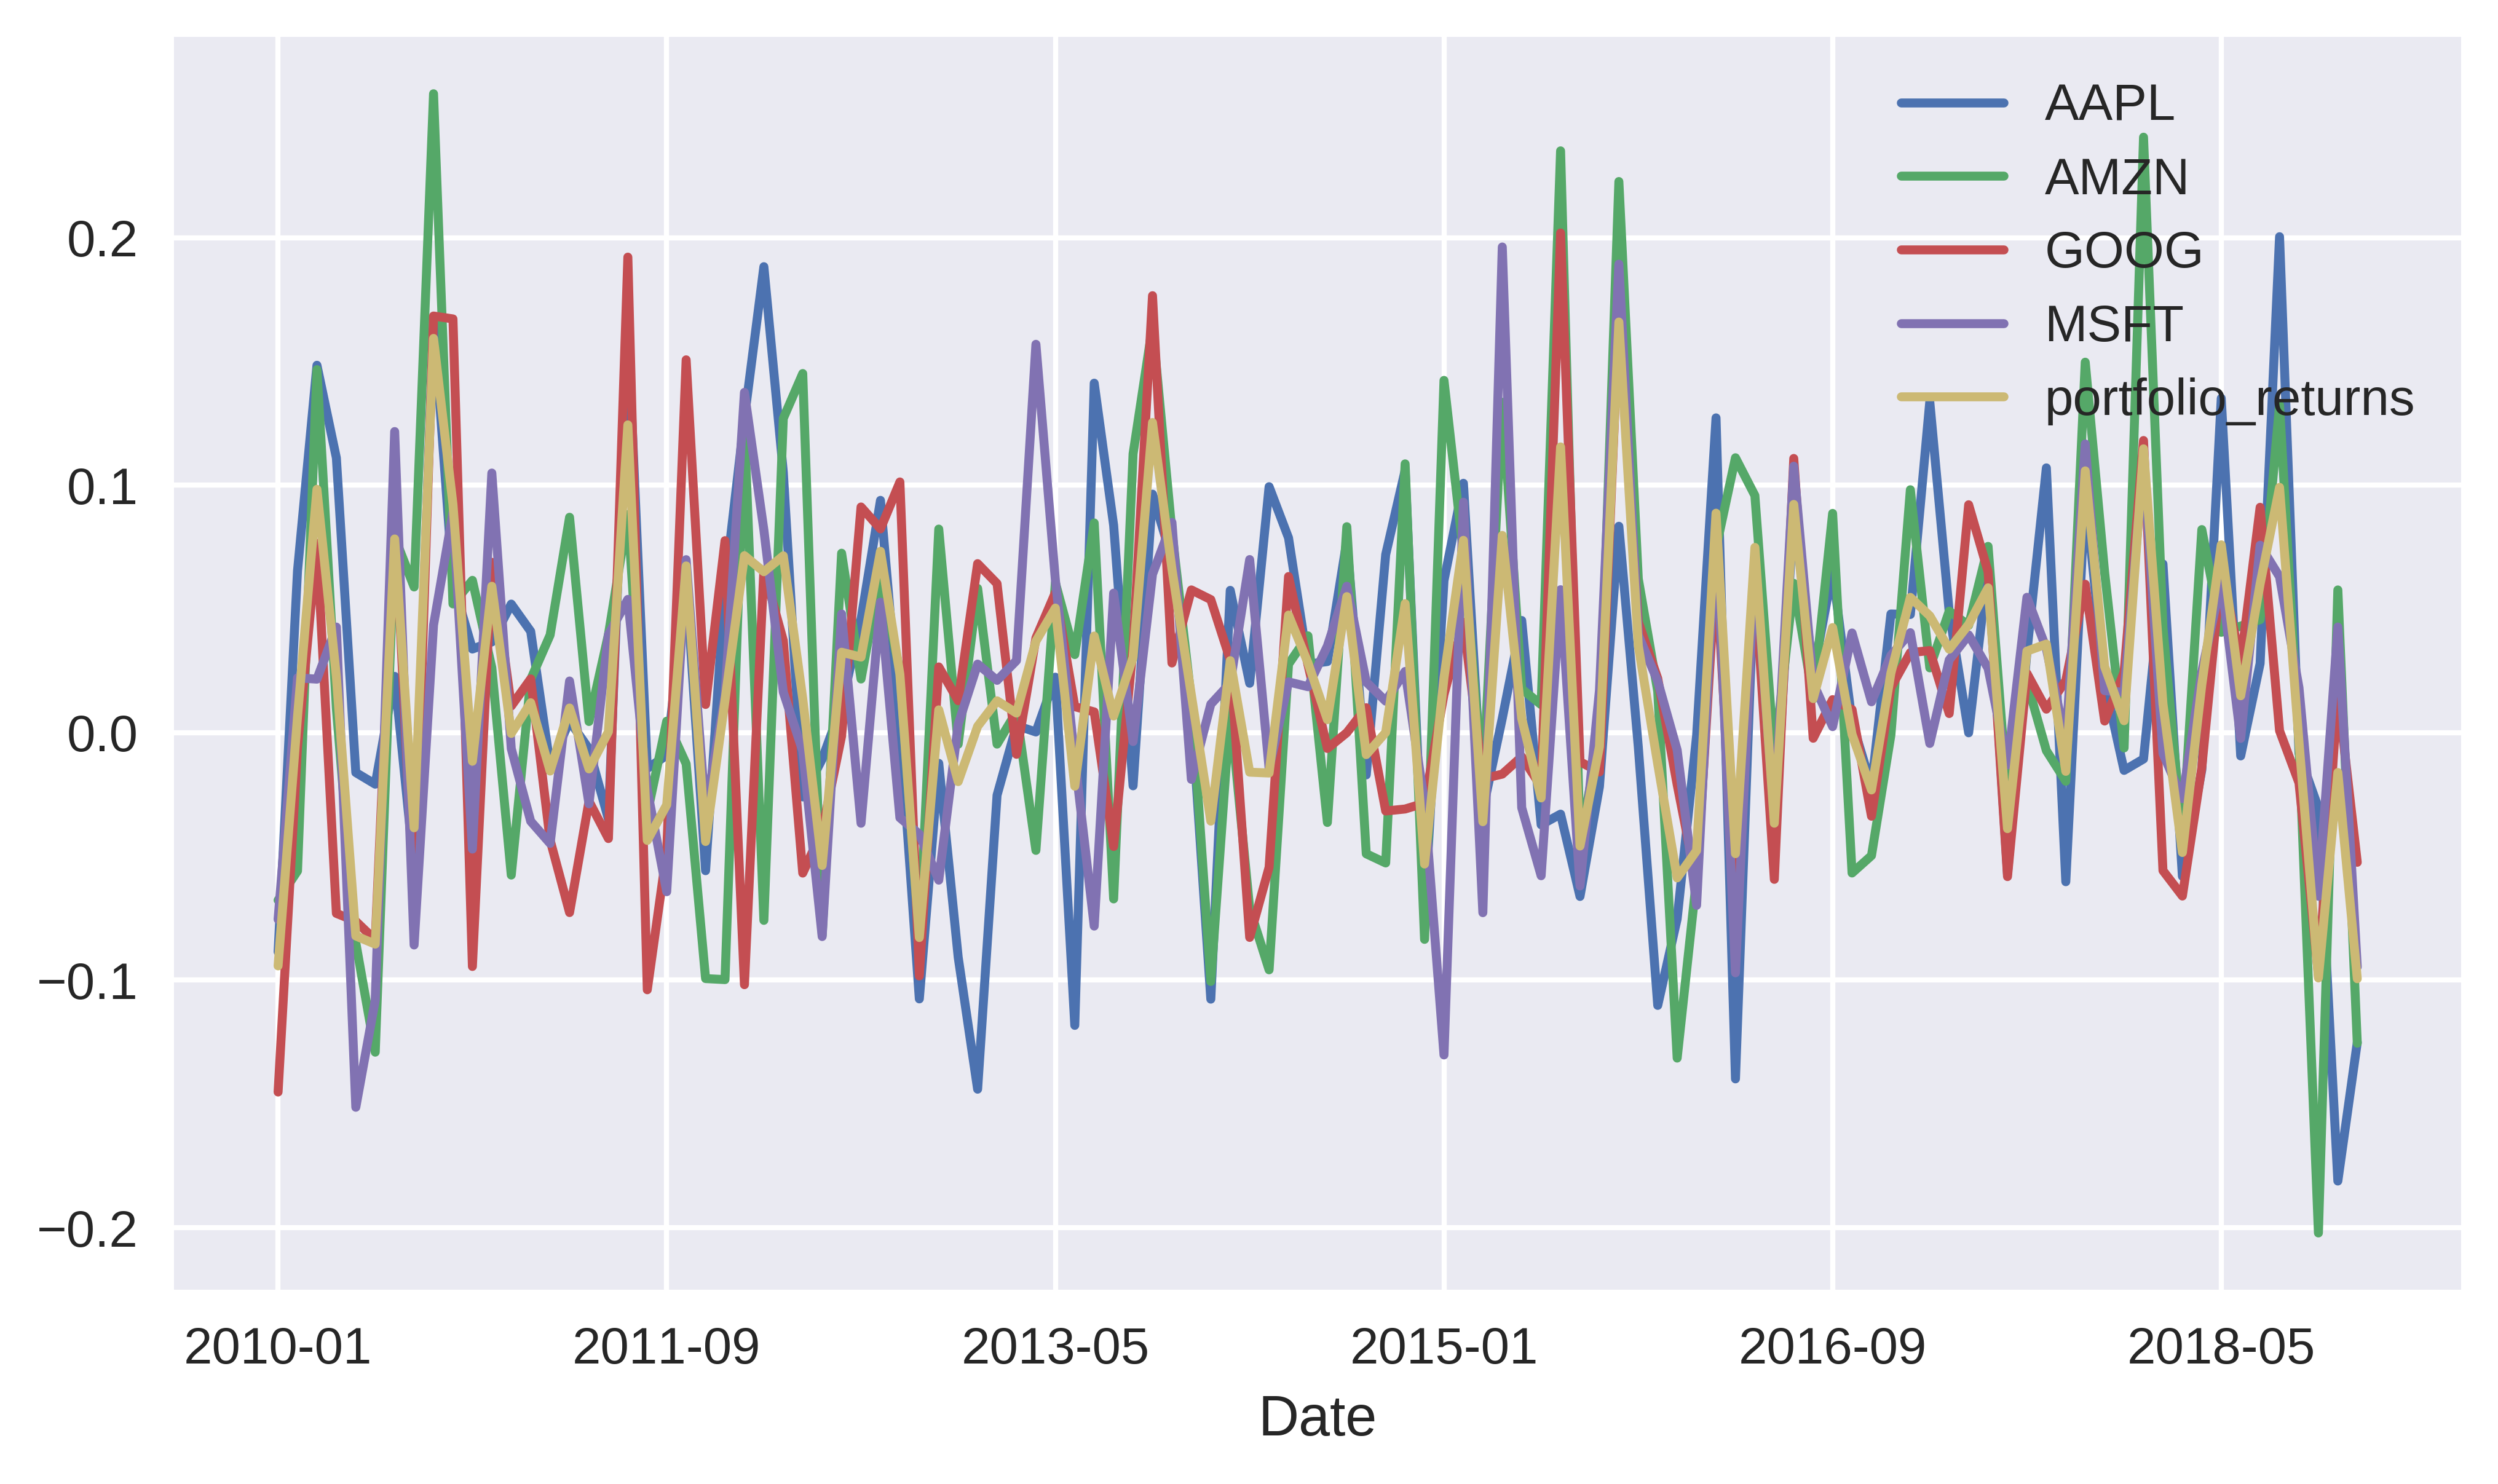

In [65]:
asset_df.plot()

In [67]:
# 데이터셋 병합
ff_data = asset_df.join(df_three_factor).drop(ASSETS, axis=1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf # 포트폴리오 초과 수익률
ff_data.head()

,portf_rtn,mkt,smb,hml,rf,portf_ex_rtn
Date,,,,,,
2010-01,-0.094252,-0.0336,0.0040,0.0043,0.0000,-0.094252
2010-02,0.006430,0.0340,0.0119,0.0322,0.0000,0.006430
2010-03,0.098335,0.0631,0.0148,0.0221,0.0001,0.098235
2010-04,0.022615,0.0200,0.0487,0.0289,0.0001,0.022515
2010-05,-0.082161,-0.0789,0.0009,-0.0244,0.0001,-0.082261


In [68]:
# 롤링 n-팩터 모델의 함수를 정의
def rolling_factor_model(input_data, formula, window_size):
    '''
    Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns
    formula : str
        `statsmodels` compatible formula representing the OLS regression  
    window_size : int
        Rolling window length.
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration.
    '''

    coeffs = []

    for start_index in range(len(input_data) - window_size + 1):        
        end_index = start_index + window_size

        # define and fit the regression model 
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_index:end_index]
        ).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

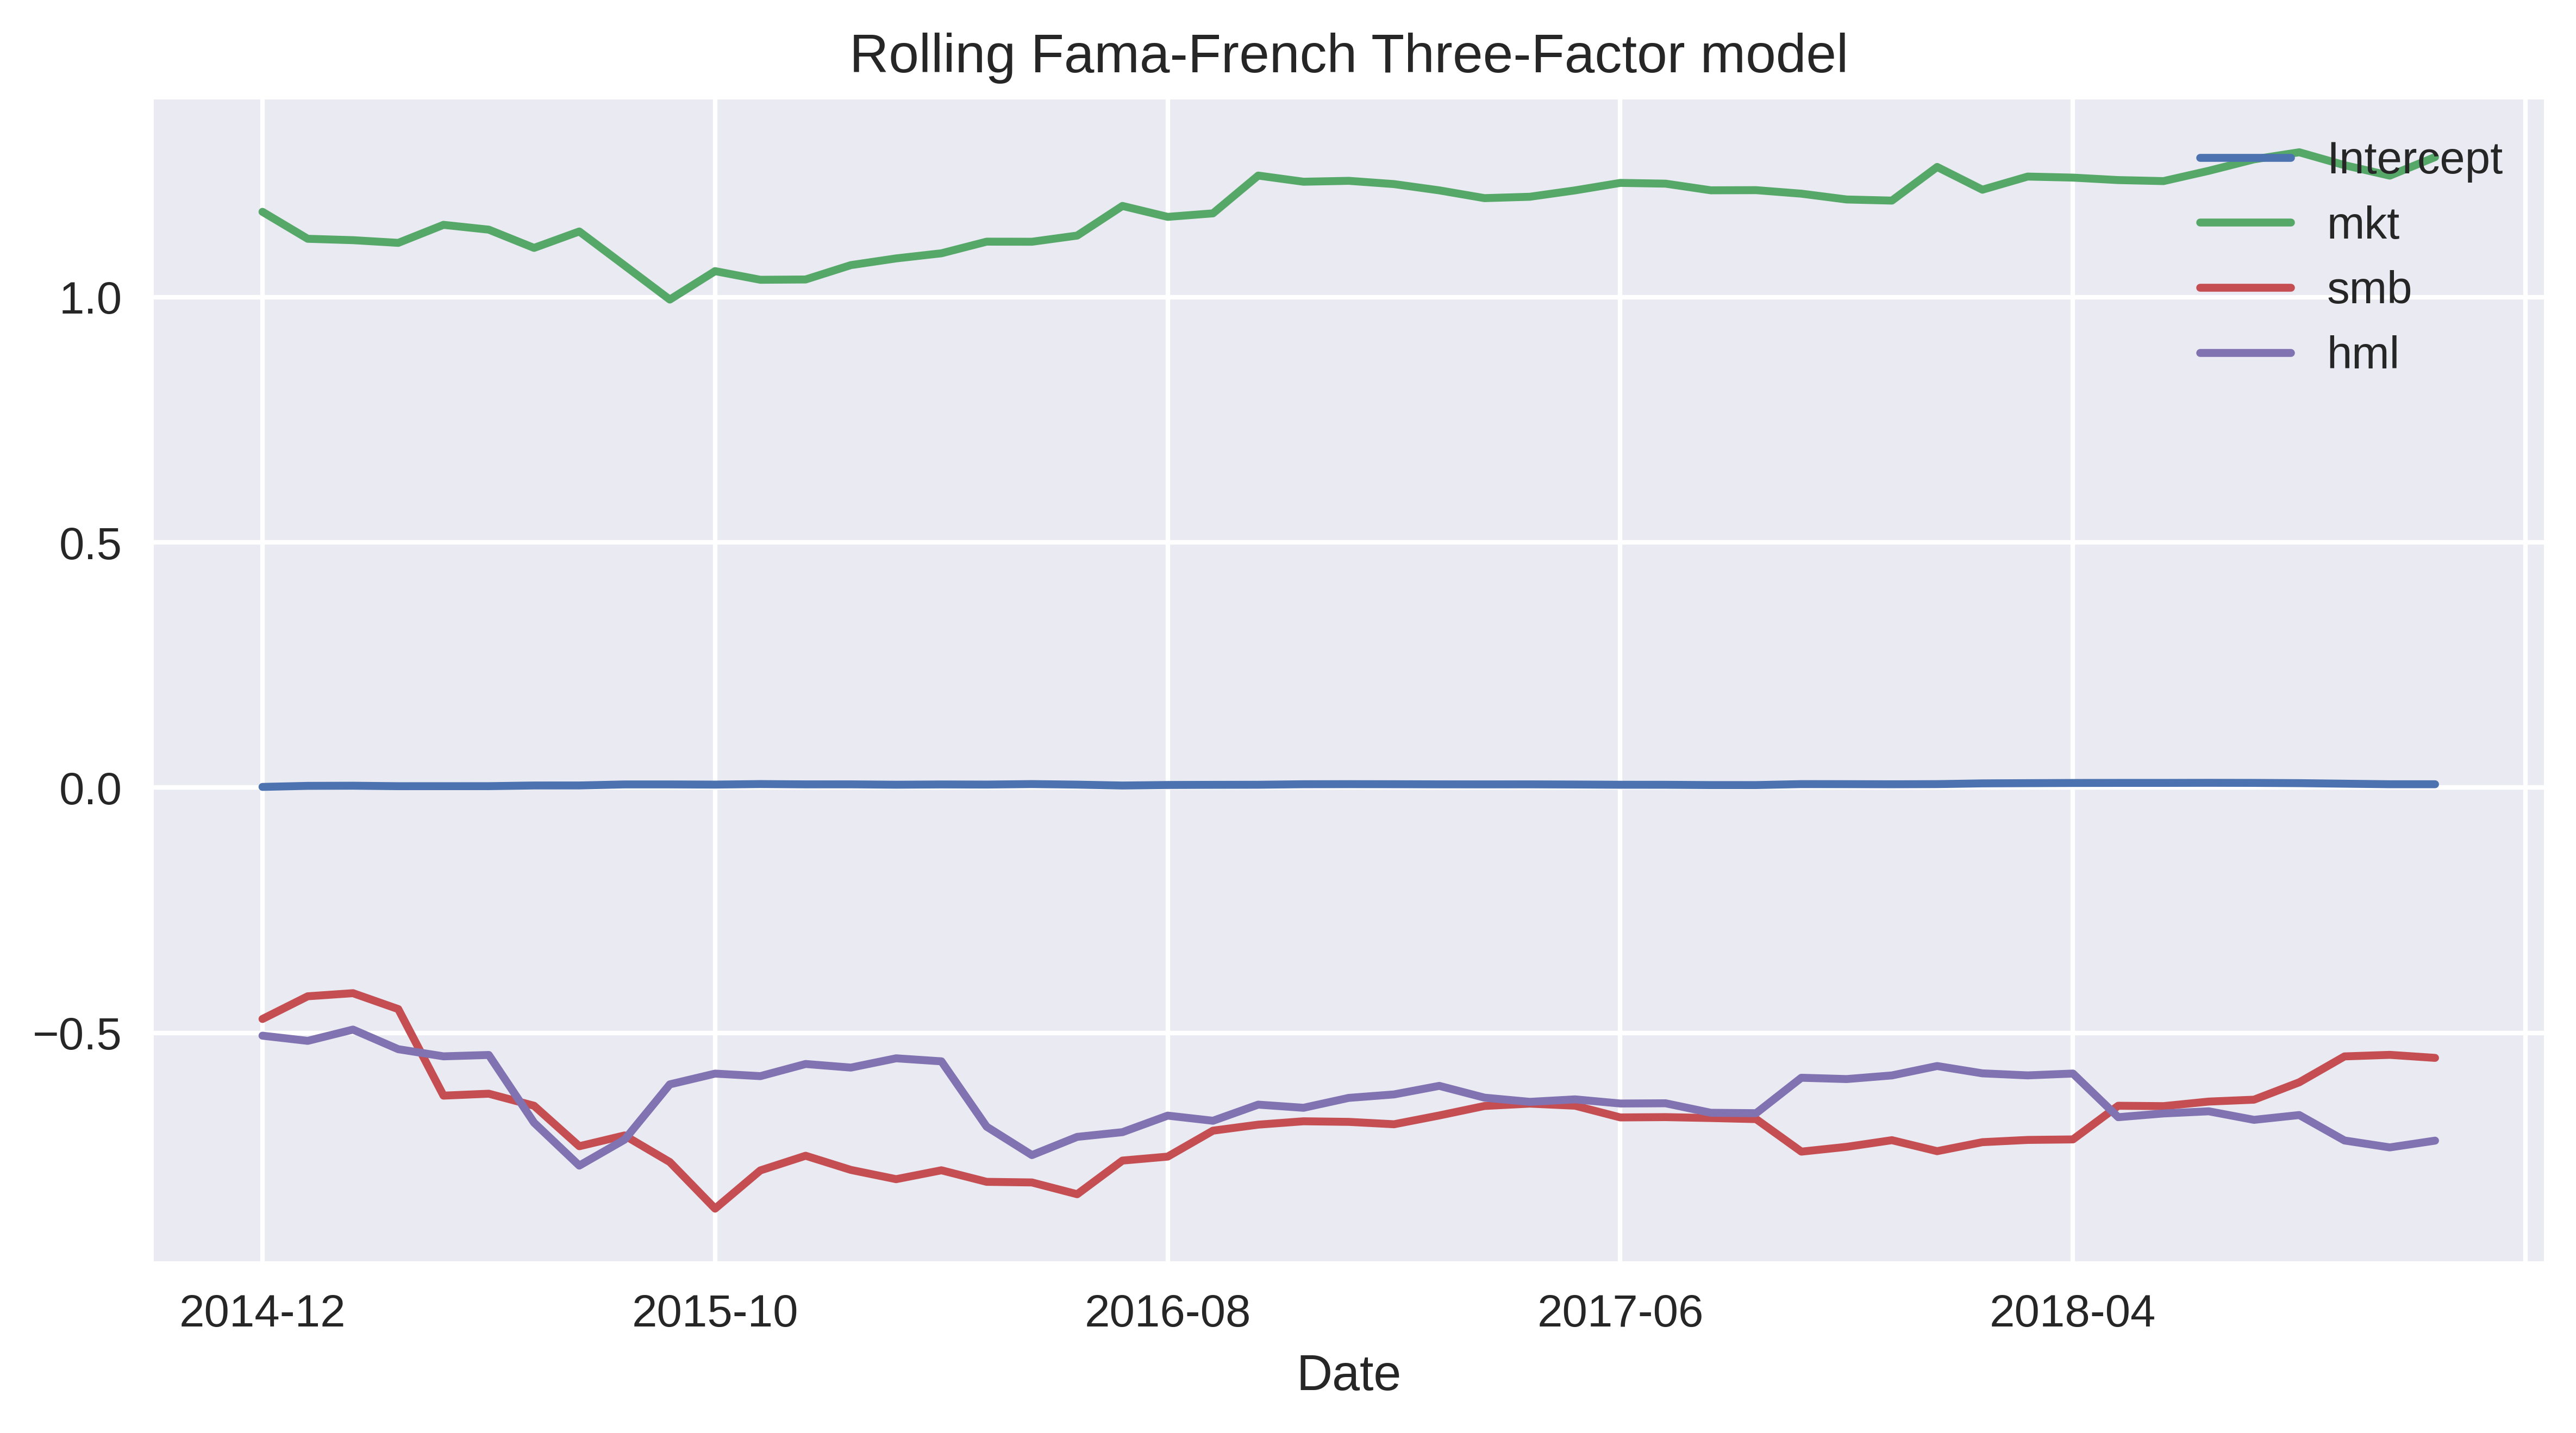

In [69]:
# 롤링 3-팩터 모델을 추정하고 결과 도식화
MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, 
                                  MODEL_FORMULA, 
                                  window_size=60) # 60개월
results_df.plot(title = 'Rolling Fama-French Three-Factor model')

plt.tight_layout()
plt.show()

- 절편은 거의 상수이며 0에 가깝다.
- 팩터에 약간의 변동성이 있지만 갑작스러운 반전이나 예상치 못한 점프는 없다.

# 4. 파이썬으로 4-팩터와 5-팩터 모델 구현
- 파마-프렌치 3-팩터 모델의 두 가지 확장 구현
- 카하트의 4-팩터 모델 : 단기간에는 승자 주식은 승자로 남고 패자는 패자로 남는다. 두 그룹을 식별한 후, 특정 보유 기간 내에 승자를 매수하고 패자를 매도한다.
- 모멘텀 팩터 : 과거 12개월 동안의 패자 주식에 대한 승자 주식의 초과 수익을 측정
- 파마-프렌치의 5-팩터 모델 : 3-팩터 모델에 두 가지 팩터를 추가해 확장
- 1. RMW : 이윤이 낮은 회사에 비해 이윤이 높은 회사의 초과 수익률 측정
- 2. CMA : 저투자 정책(보수적) 회사의 중급 이상 투자 정책(공격적) 회사 대비 초과 이익률 측정
- 모든 팩터 모델에서처럼 위험 팩터에 대한 노출이 예상 수익 대비 모든 가능한 변동을 포착하는 경우에는 모든 자산/포트폴리오의 절편(α)는 0이다.
- 2014~2018년 아마존 월별 수익률을 4,5-팩터 모델로 설명

In [78]:
# 라이브러리 불러오기
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

In [79]:
# 위험 자산과 시간 구간을 설정
RISKY_ASSET = 'AMZN'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

In [80]:
## 프렌치 교수의 웹사이트에서 위험 팩터 다운로드
# three factors 
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]
df_three_factor.index = df_three_factor.index.format()

# momentum factor
df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', 
                        start=START_DATE)[0]
df_mom.index = df_mom.index.format()

# five factors
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                                'famafrench', 
                                start=START_DATE)[0]
df_five_factor.index = df_five_factor.index.format()

In [81]:
# 야후 파이낸스에서 위험 자산 데이터 다운로드
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


In [82]:
# 월별 수익률 계산
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'return'

In [87]:
## 4-팩터 요인을 위한 데이터셋 병합
# 모든 데이터셋을 인덱스에 조인한다.
four_factor_data = df_three_factor.join(df_mom).join(y)

# 열 이름 바꾸기
four_factor_data.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'rtn']

# 모든 것(수익률 제외)을 100으로 나눔
four_factor_data.loc[:, four_factor_data.columns != 'rtn'] /= 100

# 인덱스를 datetime으로 변환
four_factor_data.index = pd.to_datetime(four_factor_data.index, 
                                        format='%Y-%M')

# 관심 대상 기간 설정
four_factor_data = four_factor_data.loc[START_DATE:END_DATE]

# 초과 수익률 계산
four_factor_data['excess_rtn'] = four_factor_data.rtn - four_factor_data.rf

four_factor_data.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
2014-01-01 00:01:00,-0.0332,0.0092,-0.0202,0.0,0.0171,-0.100554,-0.100554
2014-01-01 00:02:00,0.0465,0.0037,-0.0031,0.0,0.0207,0.009507,0.009507
2014-01-01 00:03:00,0.0043,-0.0187,0.0492,0.0,-0.0329,-0.071058,-0.071058
2014-01-01 00:04:00,-0.0019,-0.0420,0.0114,0.0,-0.0389,-0.095847,-0.095847
2014-01-01 00:05:00,0.0206,-0.0189,-0.0013,0.0,0.0088,0.027685,0.027685


 *주의*
- 나중에 여러 데이터셋을 조인하고자 PeriodIndex를 제거해야 했기 때문에 format 메서드를 인덱스에 적용

In [89]:
## 5-팩터 모델을 위한 데이터셋 병합
# 인덱스에 모든 데이터셋 병합
five_factor_data = df_five_factor.join(y)

# 열 이름 변경
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']

# 모든 것(수익률 제외)을 100으로 나눔
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

# 인덱스를 datetime으로 변경
five_factor_data.index = pd.to_datetime(five_factor_data.index, 
                                        format='%Y-%M')

# 관심 대상 기간 설정
five_factor_data = five_factor_data.loc[START_DATE:END_DATE]

# 초과 수익률 계산
five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf

five_factor_data.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2014-01-01 00:01:00,-0.0332,0.0059,-0.0202,-0.0388,-0.0143,0.0,-0.100554,-0.100554
2014-01-01 00:02:00,0.0465,0.0016,-0.0031,-0.0023,-0.0048,0.0,0.009507,0.009507
2014-01-01 00:03:00,0.0043,-0.0113,0.0492,0.0211,0.0198,0.0,-0.071058,-0.071058
2014-01-01 00:04:00,-0.0019,-0.0413,0.0114,0.0345,0.0103,0.0,-0.095847,-0.095847
2014-01-01 00:05:00,0.0206,-0.0189,-0.0013,0.0005,-0.0101,0.0,0.027685,0.027685


In [90]:
# 4-팩터 모델 추정
four_factor_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml + mom', 
                            data=four_factor_data).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     17.00
Date:                Sat, 26 Mar 2022   Prob (F-statistic):           3.97e-09
Time:                        03:51:38   Log-Likelihood:                 86.461
No. Observations:                  60   AIC:                            -162.9
Df Residuals:                      55   BIC:                            -152.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0093      0.008      1.159      0.2

- statsmodels 라이브러리에서 함수적 형태의 OLS 회귀를 사용해 모델 추정
- 함수 형태는 회귀 방정식에 절편을 자동으로 추가

In [91]:
# 5-팩터 모델 추정
five_factor_model = smf.ols(
    formula='excess_rtn ~ mkt + smb + hml + rmw + cma', 
    data=five_factor_data
).fit()

print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     15.98
Date:                Sat, 26 Mar 2022   Prob (F-statistic):           1.21e-09
Time:                        03:52:00   Log-Likelihood:                 89.565
No. Observations:                  60   AIC:                            -167.1
Df Residuals:                      54   BIC:                            -154.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0099      0.008      1.292      0.2

- 5-팩터 모델에 따르면 아마존의 초과 수익률은 대부분의 팩터(시장 팩터 제외)로부터 부정적인 영향을 받음 -> 계수 추정치가 음수
- 시장 팩터가 1% 증가하면 0.15pp 가 증가 -> 시장 팩터에 의한 1%의 수익률 상황에서는 우리의 포트폴리오는 무위험 금리 대비 1.5508*1% 초과한 수익률을 예상 가능
- 3-팩터 모델과 유사하게 5-팩터 모델이 초과 재고 수익률을 완전히 설명한다면 추정 절편은 통계적으로 0과 구별할 수 없어야 한다.